In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import numpy as np

In [2]:
# target dist: N(2, 0.5)
# source dist: N(0, 1)

In [2]:
def source_distribution(n_samples):
  return torch.randn(n_samples, 1)

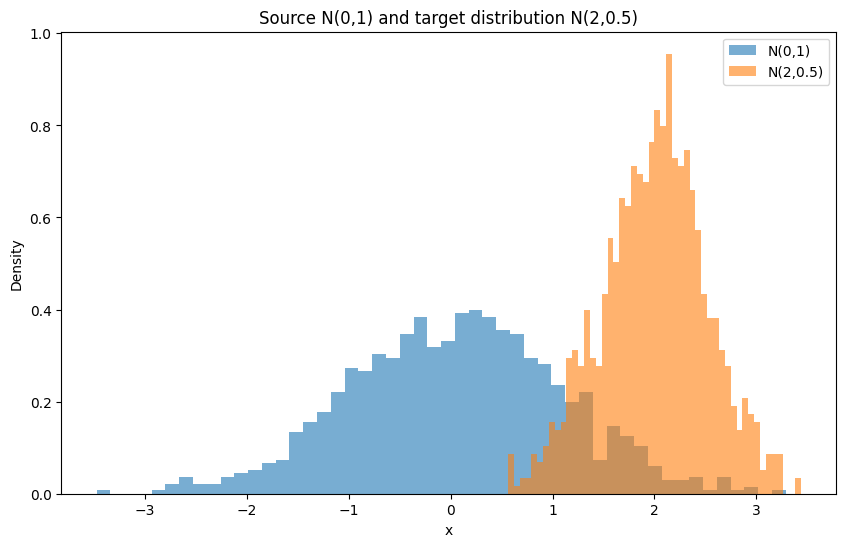

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(source_distribution(1000).numpy(), bins=50, density=True, alpha=0.6, label='N(0,1)')
plt.hist(torch.normal(2.0, 0.5, (1000, 1)).numpy(),bins=50, density=True, alpha=0.6, label='N(2,0.5)')
plt.legend()
plt.title('Source N(0,1) and target distribution N(2,0.5)')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

In [4]:
# # forward simulation
# for t in time_steps[:-1]:
#   t_tensor = t * torch.ones(n_samples, 1)
#   v = model(x, t_tensor.to(device)) # the velocity field is a neural network that takes the current distribution
#   x = x + v * dt
#   # finding v is equivalent to solving an ODE and it's known as Euler's method

In [5]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class VelocityField(nn.Module):
  def __init__(self, input_dim = 1, hidden_dim = 128):
    super(VelocityField, self).__init__()
    self.input_layer = nn.Linear(input_dim + 1, hidden_dim)
    self.norm1 = nn.LayerNorm(hidden_dim)
    self.hidden1 = nn.Linear(hidden_dim, hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, input_dim)
    self.relu = nn.ReLU()

  def forward(self, t, x):
    t_tensor = t * torch.ones(x.shape[0], 1, device = x.device)
    xt = torch.cat([x, t_tensor], dim = -1)
    h = self.relu(self.norm1(self.input_layer(xt)))
    h = h + self.relu(self.norm2(self.hidden1(h))) # residue helps a model to pass gradients more easily and robustly.
    h = h + self.relu(self.norm3(self.hidden2(h)))
    return self.output_layer(h)

In [7]:
model = VelocityField(hidden_dim=128)
model.to(device)

VelocityField(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (hidden1): Linear(in_features=128, out_features=128, bias=True)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (hidden2): Linear(in_features=128, out_features=128, bias=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [8]:
# MMD(Maximum Mean Discrepancy) is a better loss function to compare the distributions.
# As KL-Divergence cannot be computed on samples (which we have here), we will use MMD for this.
# MMD loss works for any arbitrary target distributions such as Gaussian Mixtures.

def compute_mmd(x, y, sigma = 1.0):
  """
    Compute Maximum Mean Discrepancy (MMD) between two sets of samples using a Gaussian kernel.
    x: Generated samples (n_samples, dim)
    y: Target samples (n_samples, dim)
    sigma: Kernel bandwidth
  """
  n = x.shape[0]
  m = y.shape[0]

  # pairwise squared distances
  xx = torch.sum(x**2, dim=1, keepdim=True) - 2 * torch.mm(x, x.t()) + torch.sum(x**2, dim=1, keepdim=True).t()
  yy = torch.sum(y**2, dim=1, keepdim=True) - 2 * torch.mm(y, y.t()) + torch.sum(y**2, dim=1, keepdim=True).t()
  xy = torch.sum(x**2, dim=1, keepdim=True) - 2 * torch.mm(x, y.t()) + torch.sum(y**2, dim=1, keepdim=True).t()

  # Gaussian Kernel: k(x,y) = exp(-||x-y||^2 / (2 * sigma^2))
  kernel_xx = torch.exp(-xx / (2 * sigma**2))
  kernel_yy = torch.exp(-yy / (2 * sigma**2))
  kernel_xy = torch.exp(-xy / (2 * sigma**2))

  # MMD^2 = E[k(x,x')] + E[k(y,y')] - 2 E[k(x,y)]
  mmd = (kernel_xx.sum() / (n*n)) + (kernel_yy.sum() / (m*m)) - (2 * kernel_xy.sum() / (m*n))
  return mmd


In [10]:
# Training loop

n_steps = 100
n_samples = 1000
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
time_steps = torch.linspace(0, 1, n_steps)
dt = time_steps[1] - time_steps[0]

for epoch in range(epochs+1):
  # source sampling
  x0 = source_distribution(n_samples).to(device)
  x = x0.clone().to(device)
  # target_samples = torch.normal(2.0, 0.5, (n_samples, 1)).to(device)
  target_samples = torch.cat([
      torch.normal(2.0, 0.5, (n_samples//2, 1)),
      torch.normal(-3.0, 0.5, (n_samples//2, 1))
  ]).to(device)

  # forward simulation
  for t in time_steps[:-1]:
    t_tensor = t * torch.ones(n_samples, 1)
    v = model(x, t_tensor.to(device))
    x = x + v * dt

  # loss
  # loss = torch.mean((x - target_samples)**2)
  loss = compute_mmd(x, target_samples) # mmd

  # optimize
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 0.9413
Epoch 10, Loss: 0.5819
Epoch 20, Loss: 0.3181
Epoch 30, Loss: 0.2753
Epoch 40, Loss: 0.2442
Epoch 50, Loss: 0.1344
Epoch 60, Loss: 0.0288
Epoch 70, Loss: 0.0139
Epoch 80, Loss: 0.0115
Epoch 90, Loss: 0.0055
Epoch 100, Loss: 0.0026


In [11]:
def generate_samples(model, n_samples=1000, n_steps=50):
    x = source_distribution(n_samples).to(device)
    time_steps = torch.linspace(0, 1, n_steps).to(device)
    dt = time_steps[1] - time_steps[0]

    with torch.no_grad():
        for t in time_steps[:-1]:
            t_tensor = t * torch.ones(n_samples, 1).to(device)
            v = model(x, t_tensor)
            x = x + v * dt
    return x

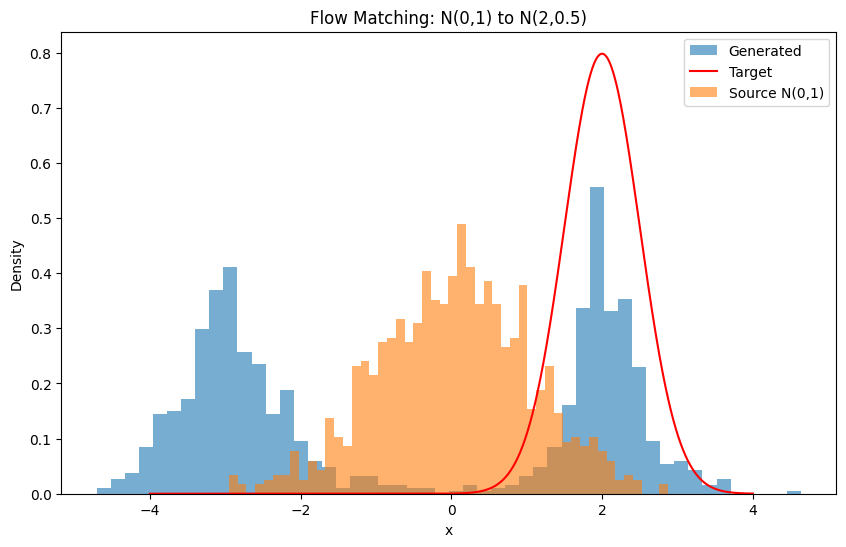

In [12]:
import matplotlib.pyplot as plt

# Generate samples
generated_samples = generate_samples(model).to('cpu')

# Plot results

# Compute clean target distribution PDF for illustration reasons
x_range = torch.linspace(-4, 4, 1000).unsqueeze(1)
mean, std = 2, 0.5
target_pdf = torch.exp(-((x_range - mean)**2) / (2 * std**2)) / (std * np.sqrt(2 * np.pi))

plt.figure(figsize=(10, 6))
plt.hist(generated_samples.numpy(), bins=50, density=True, alpha=0.6, label='Generated')
plt.plot(x_range.numpy(), target_pdf.numpy(), 'r-', label='Target')
plt.hist(source_distribution(1000).numpy(), bins=50, density=True, alpha=0.6, label='Source N(0,1)')
plt.legend()
plt.title('Flow Matching: N(0,1) to Gaussian Mixture')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

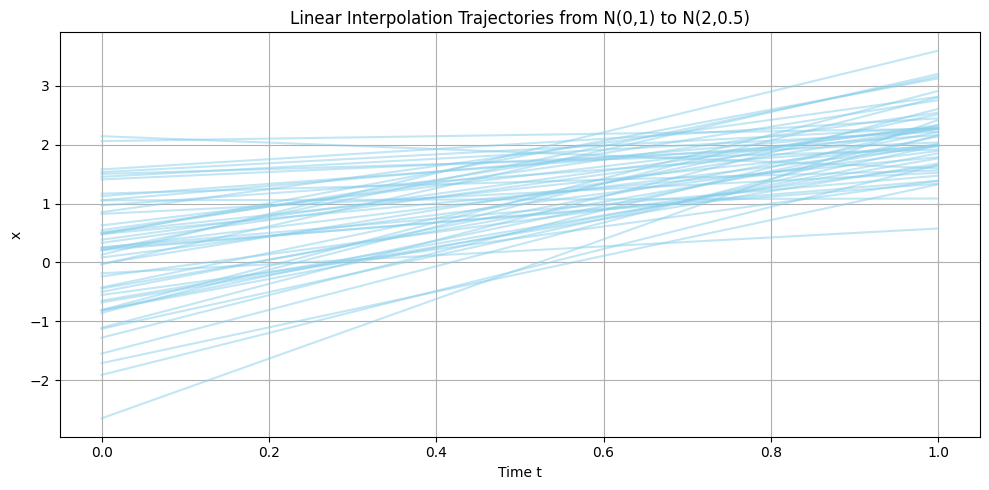

In [13]:
# Visualization of Vector Field

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Sample 1000 points from source and target distributions
n_samples = 1000
x0_samples = np.random.normal(loc=0.0, scale=1.0, size=n_samples)   # Source: N(0,1)
x1_samples = np.random.normal(loc=2.0, scale=0.5, size=n_samples)   # Target: N(2, 0.5)

# Sample t ~ Uniform(0,1) for each pair
t_samples = np.random.uniform(low=0.0, high=1.0, size=n_samples)

# Compute interpolated x_t and ground-truth velocity v*
x_t = (1 - t_samples) * x0_samples + t_samples * x1_samples
v_star = x1_samples - x0_samples

# Plot a subset of trajectories (say 50)
idx = np.random.choice(n_samples, size=50, replace=False)
x0_vis = x0_samples[idx]
x1_vis = x1_samples[idx]

# Plot
plt.figure(figsize=(10, 5))
for i in range(len(idx)):
    plt.plot([0, 1], [x0_vis[i], x1_vis[i]], color='skyblue', alpha=0.5)

plt.title("Linear Interpolation Trajectories from N(0,1) to N(2,0.5)")
plt.xlabel("Time t")
plt.ylabel("x")
plt.grid(True)
plt.tight_layout()
plt.show()

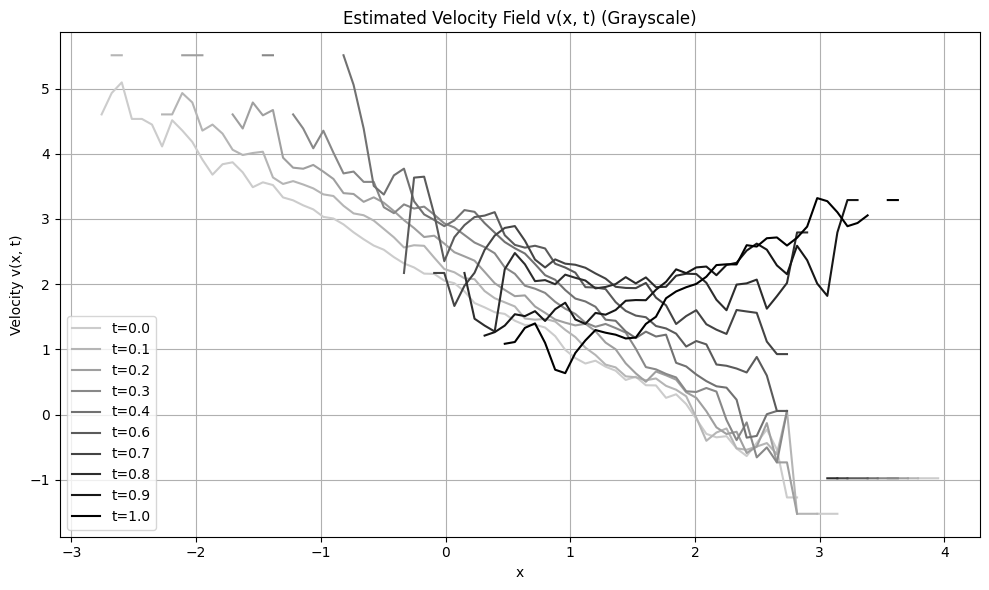

In [14]:
from scipy.stats import norm

# Create a grid over x and t to evaluate the velocity field
x_grid = np.linspace(-3, 5, 100)
t_grid = np.linspace(0, 1, 10)
X, T = np.meshgrid(x_grid, t_grid)

# For each (x, t), compute expected velocity by averaging v* over many pairs
# We'll estimate this empirically by averaging over sampled pairs whose x_t is close to (x,t)

# Use all samples to compute x_t and v*
x_t_all = (1 - t_samples[:, None]) * x0_samples[:, None] + t_samples[:, None] * x1_samples[:, None]
v_star_all = (x1_samples - x0_samples)[:, None]

# Estimate velocity field on the grid
V = np.zeros_like(X)
for i in range(len(t_grid)):
    for j in range(len(x_grid)):
        t_val = t_grid[i]
        x_val = x_grid[j]

        # Compute interpolated points for this t
        x_interp = (1 - t_val) * x0_samples + t_val * x1_samples
        v_interp = x1_samples - x0_samples

        # Find samples where x_interp is close to current x_val
        mask = np.abs(x_interp - x_val) < 0.1
        if np.sum(mask) > 0:
            V[i, j] = np.mean(v_interp[mask])
        else:
            V[i, j] = np.nan  # no data nearby

grayscale_colors = [(i, i, i) for i in np.linspace(0.8, 0.0, len(t_grid))]

plt.figure(figsize=(10, 6))
plt.clf()
for i in range(len(t_grid)):
    plt.plot(x_grid, V[i], color=grayscale_colors[i], label=f't={t_grid[i]:.1f}')

plt.title("Estimated Velocity Field v(x, t) (Grayscale)")
plt.xlabel("x")
plt.ylabel("Velocity v(x, t)")
plt.grid(True)
plt.legend()  # This ensures the legend appears
plt.tight_layout()
plt.show()